### Importing the Libraries and Installing the Packages

In [19]:
import nltk
import json
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import random
from sklearn.model_selection import train_test_split
import pickle
!pip install torchviz
!pip install joblib

### Downloading NLP Packages

In [2]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ritur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ritur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Processing Data 

In [22]:
stemmer = WordNetLemmatizer()

words = []
classes = []
documents = []
ignore_words = ['?']

# Read intents from the JSON file
with open('../Dataset/University_Data.json', 'r',encoding="UTF-8") as file:
    intents = json.load(file)

for intent in intents['intents']:
    for pattern in intent['questions']:
        # Tokenize each word in the sentence
        w = nltk.word_tokenize(pattern)
        # Add to our words list
        words.extend(w)
        # Add to documents in our corpus
        documents.append((w, intent['tag']))
        # Add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])


words = [stemmer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))


classes = sorted(list(set(classes)))

print(len(documents), "documents")
print(len(classes), "classes", classes)
print(len(words), "Lemmatized words", words)

# Load classes and words from the .pkl file
with open('words.pkl', 'wb') as file:
     pickle.dump(words, file)
    
with open('classes.pkl', 'wb') as file:
    pickle.dump(classes, file)


554 documents
215 classes ['CAPS_statistics', 'about_stockton', 'academic_performance', 'account_funding_methods', 'accreditation', 'additional_recommendation_letters', 'admission_requirements', 'admissions_coordinator_meeting', 'advising_appointment', 'allow_others_access', 'annual_disclosure_statement', 'application_status', 'application_status_explanation', 'appointment', 'appointment_timing', 'around_campus_activities', 'attendance_orientation', 'attire_recommendation', 'balance_limits', 'benefits_of_pacificcash', 'bringing_car_to_campus', 'campus_address', 'campus_food_quality', 'campus_tours', 'campus_vibes', 'cancellation_orientation', 'card_fees', 'certification_process', 'chan_family_hall_relocation', 'change_major_orientation', 'charge_at_bookstore', 'check_in_orientation', 'class_structure', 'cleaning_residence', 'clothing_swap_items', 'clothing_swap_participation', 'co-op_program', 'community_influence', 'conference_funding', 'confidentiality_concerns', 'consulting_about_st

In [4]:
training = []
output = []
output_empty = [0] * len(classes)

# Training set, bag of words for each sentence
for doc in documents:
    # Initialize our bag of words
    bag = []
    # List of tokenized words for the pattern
    pattern_words = doc[0]
    # Lemmatize each word
    pattern_words = [stemmer.lemmatize(word.lower()) for word in pattern_words]
    # Create our bag of words arrays
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)
    # Output is a '0' for each tag and '1' for the current tag
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    training.append([bag, output_row])
random.shuffle(training)
def synonym_replacement(tokens, limit):
    augmented_sentences = []
    for i in range(len(tokens)):
        synonyms = []
        for syn in wordnet.synsets(tokens[i]):
            for lemma in syn.lemmas():
                synonyms.append(lemma.name())
        if len(synonyms) > 0:
            num_augmentations = min(limit, len(synonyms))
            sampled_synonyms = random.sample(synonyms, num_augmentations)
            for synonym in sampled_synonyms:
                augmented_tokens = tokens[:i] + [synonym] + tokens[i + 1:]
                augmented_sentences.append(' '.join(augmented_tokens))
    return augmented_sentences


# Augment the training data using synonym replacement
augmented_data = []
limit_per_tag = 100

for i, doc in enumerate(training):
    bag, output_row = doc
    tokens = [words[j] for j in range(len(words)) if bag[j] == 1]
    augmented_sentences = synonym_replacement(tokens, limit_per_tag)
    for augmented_sentence in augmented_sentences:
        augmented_bag = [1 if augmented_sentence.find(word) >= 0 else 0 for word in words]
        augmented_data.append([augmented_bag, output_row])

# Convert training and augmented_data to NumPy arrays
training_array = np.array(training, dtype=object)
augmented_data_array = np.array(augmented_data, dtype=object)

# Concatenate the arrays
combined_data = np.concatenate((training_array, augmented_data_array), axis=0)

# Shuffle the combined data
np.random.shuffle(combined_data)

### Splitting the Training and Test Dataset

In [5]:
def separate_data_by_tags(data):
    data_by_tags = {}
    for d in data:
        tag = tuple(d[1])
        if tag not in data_by_tags:
            data_by_tags[tag] = []
        data_by_tags[tag].append(d)
    return data_by_tags.values()


separated_data = separate_data_by_tags(combined_data)

# Lists to store training and testing data
training_data = []
testing_data = []

# Split each tag's data into training and testing sets
for tag_data in separated_data:
    train_data, test_data = train_test_split(tag_data, test_size=0.2, random_state=42)
    training_data.extend(train_data)
    testing_data.extend(test_data)
random.shuffle(training_data)
random.shuffle(testing_data)

# Convert training and testing data back to np.array
train_x = np.array([d[0] for d in training_data])
train_y = np.array([d[1] for d in training_data])
test_x = np.array([d[0] for d in testing_data])
test_y = np.array([d[1] for d in testing_data])

### Training the chatbot Model

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        output = self.softmax(x)
        return output

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return self.softmax(x)

class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

def accuracy(predictions, targets):
    predicted_labels = torch.argmax(predictions, dim=1)
    true_labels = torch.argmax(targets, dim=1)
    correct = (predicted_labels == true_labels).sum().item()
    total = targets.size(0)
    return correct / total

def test_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    num_batches = len(test_loader)

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            total_accuracy += accuracy(outputs, targets) * inputs.size(0)

    average_loss = total_loss / len(test_loader.dataset)
    average_accuracy = total_accuracy / len(test_loader.dataset)
    return average_loss, average_accuracy

In [7]:
# Create DataLoader for training and testing data
train_x = torch.tensor(train_x).float()
train_y = torch.tensor(train_y).float()
test_x = torch.tensor(test_x).float()
test_y = torch.tensor(test_y).float()

batch_size = 100 
train_dataset = CustomDataset(train_x, train_y)
test_dataset = CustomDataset(test_x, test_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the model, loss function, and optimizer
input_size = len(train_x[0])
hidden_size = 8
output_size = len(train_y[0])
model = NeuralNetwork(input_size, hidden_size, output_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# Lists to store training and testing loss values
train_losses = []
test_losses = []

# Lists to store training and testing accuracy values
train_accuracies = []
test_accuracies = []

# Train the model and evaluate on the testing set
num_epochs = 100
for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update statistics
        running_loss += loss.item() * inputs.size(0)
        running_acc += accuracy(outputs, targets) * inputs.size(0)

    # Calculate average training loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_acc / len(train_loader.dataset)

    # Store training loss and accuracy for plotting
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Print training loss and accuracy for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")

    # Evaluate on the testing set
    test_loss, test_accuracy = test_model(model, test_loader, criterion)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}")

# Save the trained model
torch.save(model.state_dict(), 'model.pth')

Epoch [1/100], Training Loss: 0.0218, Training Accuracy: 0.2159
Epoch [1/100], Testing Loss: 0.0133, Testing Accuracy: 0.5305
Epoch [2/100], Training Loss: 0.0083, Training Accuracy: 0.7360
Epoch [2/100], Testing Loss: 0.0050, Testing Accuracy: 0.8689
Epoch [3/100], Training Loss: 0.0037, Training Accuracy: 0.8936
Epoch [3/100], Testing Loss: 0.0027, Testing Accuracy: 0.9241
Epoch [4/100], Training Loss: 0.0022, Training Accuracy: 0.9339
Epoch [4/100], Testing Loss: 0.0018, Testing Accuracy: 0.9455
Epoch [5/100], Training Loss: 0.0015, Training Accuracy: 0.9520
Epoch [5/100], Testing Loss: 0.0013, Testing Accuracy: 0.9572
Epoch [6/100], Training Loss: 0.0012, Training Accuracy: 0.9598
Epoch [6/100], Testing Loss: 0.0011, Testing Accuracy: 0.9610
Epoch [7/100], Training Loss: 0.0010, Training Accuracy: 0.9652
Epoch [7/100], Testing Loss: 0.0009, Testing Accuracy: 0.9639
Epoch [8/100], Training Loss: 0.0008, Training Accuracy: 0.9672
Epoch [8/100], Testing Loss: 0.0008, Testing Accuracy:

# Model Inference

In [33]:
def load_model(model_path, input_size, hidden_size, output_size):
    model = NeuralNetwork(input_size, hidden_size, output_size)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Function to preprocess the input sentence
def preprocess_sentence(sentence, words):
    sentence_words = sentence.lower().split()
    sentence_words = [word for word in sentence_words if word in words]
    return sentence_words

# Function to convert the preprocessed sentence into a feature vector
def sentence_to_features(sentence_words, words):
    features = [1 if word in sentence_words else 0 for word in words]
    return torch.tensor(features).float().unsqueeze(0)

# Function to generate a response using the trained model
def generate_response(sentence, model, words, classes):
    sentence_words = preprocess_sentence(sentence, words)
    if len(sentence_words) == 0:
        return "I'm sorry, but I don't understand. Can you please rephrase or provide more information?"

    features = sentence_to_features(sentence_words, words)
    with torch.no_grad():
        outputs = model(features)

    probabilities, predicted_class = torch.max(outputs, dim=1)
    confidence = probabilities.item()
    predicted_tag = classes[predicted_class.item()]
    
    #print(probabilities, predicted_class, confidence, predicted_tag)

    if confidence > 0.5:
        for intent in intents['intents']:
            if intent['tag'] == predicted_tag:
                print(intent['answer'])
                if isinstance(intent['answer'], list):
                    answers = intent['answer']
                else:
                    # Split the string into a list of answers
                    answers = intent['answer'].split('\n')
                return random.choice(answers)

    return "I'm sorry, but I'm not sure how to respond to that."

In [9]:
# Assuming your model is named 'model'
model.eval()

# Convert your X_train and X_test to PyTorch tensors
X_train_tensor = torch.tensor(train_x).float()
X_test_tensor = torch.tensor(test_x).float()

# Convert your y_train and y_test to PyTorch tensors
y_train_tensor = torch.tensor(train_y).float()
y_test_tensor = torch.tensor(test_y).float()

# Get predictions for training set
with torch.no_grad():
    outputs_train = model(X_train_tensor)

# Get predictions for testing set
with torch.no_grad():
    outputs_test = model(X_test_tensor)

# Calculate accuracy for training set
accuracy_train = accuracy(outputs_train, y_train_tensor)

# Calculate accuracy for testing set
accuracy_test = accuracy(outputs_test, y_test_tensor)

print("Training Accuracy: {:.4f}".format(accuracy_train))
print("Testing Accuracy:  {:.4f}".format(accuracy_test))

# Print model summary
print(model)


Training Accuracy: 0.9811
Testing Accuracy:  0.9712
NeuralNetwork(
  (fc1): Linear(in_features=874, out_features=8, bias=True)
  (relu1): ReLU()
  (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=8, out_features=8, bias=True)
  (relu2): ReLU()
  (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=8, out_features=215, bias=True)
  (softmax): Softmax(dim=1)
)


In [10]:
from keras.backend import clear_session
# clear states generated by Keras to reduce memory usage
clear_session()

In [11]:
from torchviz import make_dot

# Assuming your PyTorch model is named 'model'
dummy_input = torch.randn(1, input_size)  # Adjust the shape as per your input size

# Create a dummy input tensor for visualization
dot = make_dot(model(dummy_input), params=dict(model.named_parameters()))

# Save the visualization to a file (e.g., PNG)
dot.render("model_visualization", format="png", cleanup=True)


'model_visualization.png'

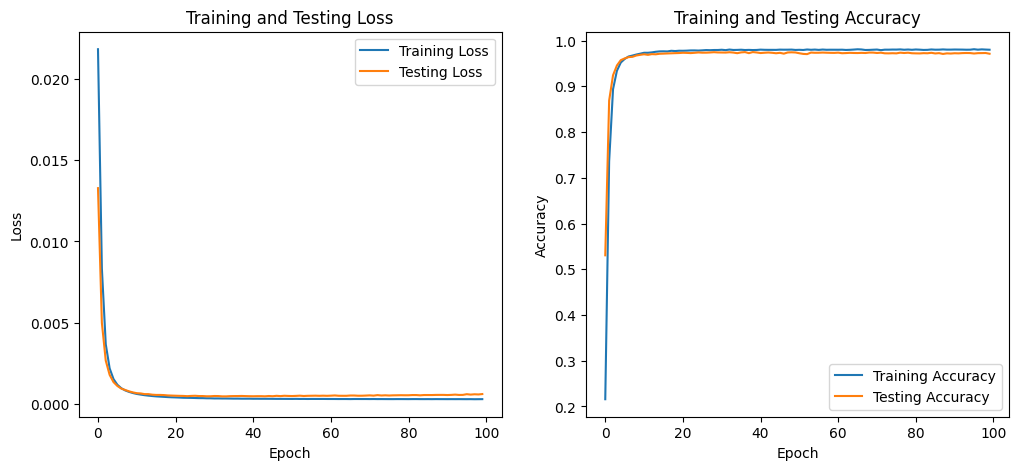

In [12]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [27]:
model_path = 'model.pth'
input_size = len(words)
hidden_size = 8
output_size = len(classes)
model = load_model(model_path, input_size, hidden_size, output_size)

print('Hello! I am a chatbot. How can I help you today? Type "quit" to exit.')
while True:
    user_input = input('> ')
    if user_input.lower() == 'quit':
        break
    answer = generate_response(user_input, model, words, classes)
    print(answer)

Hello! I am a chatbot. How can I help you today? Type "quit" to exit.
You can call me Mind Reader. I'm a Chatbot.
I was created by Pacific Bot Team.
For detailed fee information, please visit our college website.


In [34]:
import textwrap

test_cases = [
    "Hello",
    "Good Morning",
    "What are you",
    "Who Created You",
    "That is not right",
    "What is your name",
    "How do I pay rent? When is it due?",
    "Do I need to bring a car to campus or is there viable public transportation?",
    "Does the TAA require any specific course requirements?",
     "What is a Transfer Admission Agreement?",
    "What is the difference between a Transfer Admission Agreement and a Transfer Admission Guarantee?",
     "Who do I speak to about requesting a refund?",
     "I've heard Stockton is Dangerous. Is that true?",
    "What should students from other states be aware of before coming to Pacific?",
    "Describe the city of Stockton.",
     "What can you do around campus?",
     "Can and should I bring my car?",
    "What assistance is provided to first-generation students?",
    "Are the dorms nice?",
     "Tell me about the quality of food on Pacific's campus.",
     "What resources help students find jobs and internships at Pacific?",
     "How do I pay for Pacific?",
     "Where can I find the C parking lot?",
    "What is PacificCash?",
    "what can i do when when card is stolen"
]
print('Testing Cases starting..........\n')

unseen = []

import pickle

# Load classes and words from the .pkl file
with open('classes.pkl', 'rb') as file:
    classes = pickle.load(file)
    
with open('words.pkl', 'rb') as file:
    words = pickle.load(file)

for i in test_cases:
    print(i)
    print('\n')
    responses = generate_response(i.lower(), model, words, classes)
    
    # Check if responses is a list
    if isinstance(responses, list):
        response = random.choice(responses)
    else:
        response = responses

    print(textwrap.fill(response, width=70))
    print('-------------------------------------')

    if response == "I'm sorry, but I'm not sure how to respond to that.":
        unseen.append(i)

Testing Cases starting..........

Hello


['Hello!', 'Good to see you!', 'Hi there, how can I help?']
Hello!
-------------------------------------
Good Morning


['Hello!', 'Good to see you!', 'Hi there, how can I help?']
Hello!
-------------------------------------
What are you


["You can call me Mind Reader. I'm a Chatbot."]
You can call me Mind Reader. I'm a Chatbot.
-------------------------------------
Who Created You


['I was created by Pacific Bot Team.']
I was created by Pacific Bot Team.
-------------------------------------
That is not right


McGeorge School of Law offers the JD, MSL, LLM, and JSD law-related degrees and two non-law degrees — the MPP and MPA. The public policy and law degrees complement and strengthen each other. You will take at least two law courses among your required courses and more for an area of concentration. Law students may enroll in public policy courses and some students will pursue both a JD and MPP or JD and MPA degree.
McGeorge School of Law